# Prognostics for Turbofine Engines with 1D Convolutional Neural Networks 🩺

Prognostics is the prediction of Remaining useful life of instance of failure of a component based on the knowledge about current and future coditions of operation (obtained through various sensors or physical models).

The new C-MAPSS dataset DS02 from NASA provides degradation trajectories of 9 turbofan engines with unknown and different initial health condition for complete flights and two failure modes (HPT efficiency degradation & HPT efficiency degradation combined with LPT efficiency and capacity degradation). The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. A total number of 6.5M time stamps are available. Dataset copyright (c) by Manuel Arias.

**For training simplicity, the dataset has been preprocessed. The dataset has been downsampled from 1Hz to 0.1 Hz with an IIR 8th Order Chebyshev filter. Data format has been converted from double to float precison.**

## Imports 💼

In [1]:
import os
import time 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

Using MPS device


## Download dataset 🔗

Download the dataset from [Google Drive Link](https://drive.google.com/file/d/1jXC3BQmEkupXkJbuXM52-Lf6ADLzR4Rr/view?usp=sharing) and put it in the folder of this notebook.

In [3]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/ncmapps_ds02.csv


# Data exploration 🔍

<img src="images/cmapss.png" width="700"/>

### Feature descriptions

| Symbol |           Description           | Units |
|:------:|:-------------------------------:|:-----:|
|   Wf   |            Fuel flow            |  pps  |
|   Nf   |        Physical fan speed       |  rpm  |
|   Nc   |       Physical core speed       |  rpm  |
|   T24  | Total temperature at LPC outlet |   °R  |
|   T30  | Total temperature at HPC outlet |   °R  |
|   T48  | Total temperature at HPT outlet |   °R  |
|   T50  | Total temperature at LPT outlet |   °R  |
|   P15  |  Total pressure in bypass-duct  |  psia |
|   P2   |   Total pressure at fan inlet   |  psia |
|   P21  |   Total pressure at fan outlet  |  psia |
|   P24  |   Total pressure at LPC outlet  |  psia |
|  Ps30  |  Static pressure at HPC outlet  |  psia |
|   P40  | Total pressure at burner outlet |  psia |
|   P50  |   Total pressure at LPT outlet  |  psia |
|   alt  |             Altitude            |   ft  |
|  Mach  |        Flight Mach number       |   -   |
|   TRA  |     Throttle–resolver angle     |   %   |
|   T2   |  Total temperature at fan inlet |   °R  |
|  cycle |       Flight cycle number       |   -   |
|   Fc   |           Flight class          |   -   |
|   hs   |           Health state          |   -   |

In [4]:
df = pd.read_csv(filename)
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [5]:
df.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
count,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,...,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000
mean,553.773261,1305.850995,1624.971227,1095.696343,10.873508,8.294637,11.039095,13.643750,208.496462,212.067515,...,2.253705,21119.237345,0.610494,67.194135,470.945280,36.166254,2.885379,11.667088,0.242413,36.923423
std,17.911969,55.450514,98.490373,51.542820,2.151641,1.772237,2.184407,2.623686,44.015363,44.661923,...,0.570109,6289.970530,0.079231,14.527711,16.562547,21.888520,0.386773,6.039347,0.428543,21.871899
min,478.632600,1059.667800,1209.931600,880.090700,5.852047,4.347817,5.941164,6.836902,79.552380,81.277596,...,0.669135,9882.690000,0.307302,19.149189,417.287570,0.000000,1.000000,2.000000,0.000000,1.000000
25%,541.163970,1275.104050,1576.463600,1062.239200,9.047318,6.723060,9.185095,11.490683,177.011890,180.088135,...,1.862427,15698.589500,0.552379,57.695049,457.398350,18.000000,3.000000,5.000000,0.000000,18.000000
50%,551.275940,1304.876100,1634.922400,1087.750400,10.440776,7.942872,10.599772,13.147205,198.354350,201.783000,...,2.120128,21750.955000,0.623288,73.139915,469.305800,35.000000,3.000000,11.000000,0.000000,36.000000
75%,565.815665,1340.213050,1683.188100,1128.510400,12.557189,9.760832,12.748416,15.541450,235.666880,239.740805,...,2.575994,26692.051500,0.673824,78.666230,485.250000,54.000000,3.000000,18.000000,0.000000,54.000000
max,610.117900,1484.438500,1920.566000,1282.403800,16.686320,12.159272,16.940426,21.708801,376.933350,382.565220,...,4.619399,34629.797000,0.738229,91.356170,505.425720,88.000000,3.000000,20.000000,1.000000,89.000000


### Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        

<Axes: xlabel='Unit # [-]', ylabel='Flight Class # [-]'>

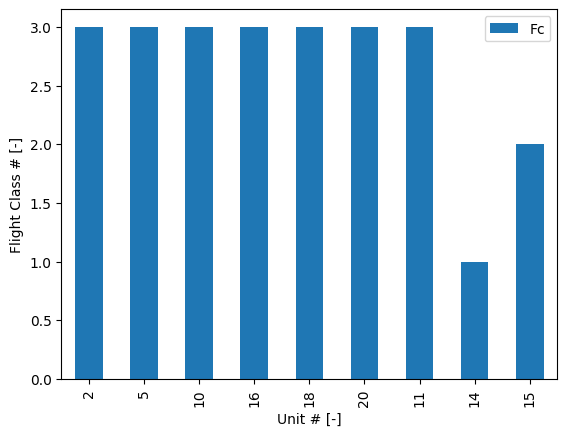

In [6]:
df.drop_duplicates(
    subset=['unit','Fc'], keep='last'
    ).plot(
        x='unit', y='Fc', 
        kind='bar', 
        xlabel='Unit # [-]', 
        ylabel='Flight Class # [-]'
    )

## Feature Overview

In [7]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [8]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [9]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Axes: >

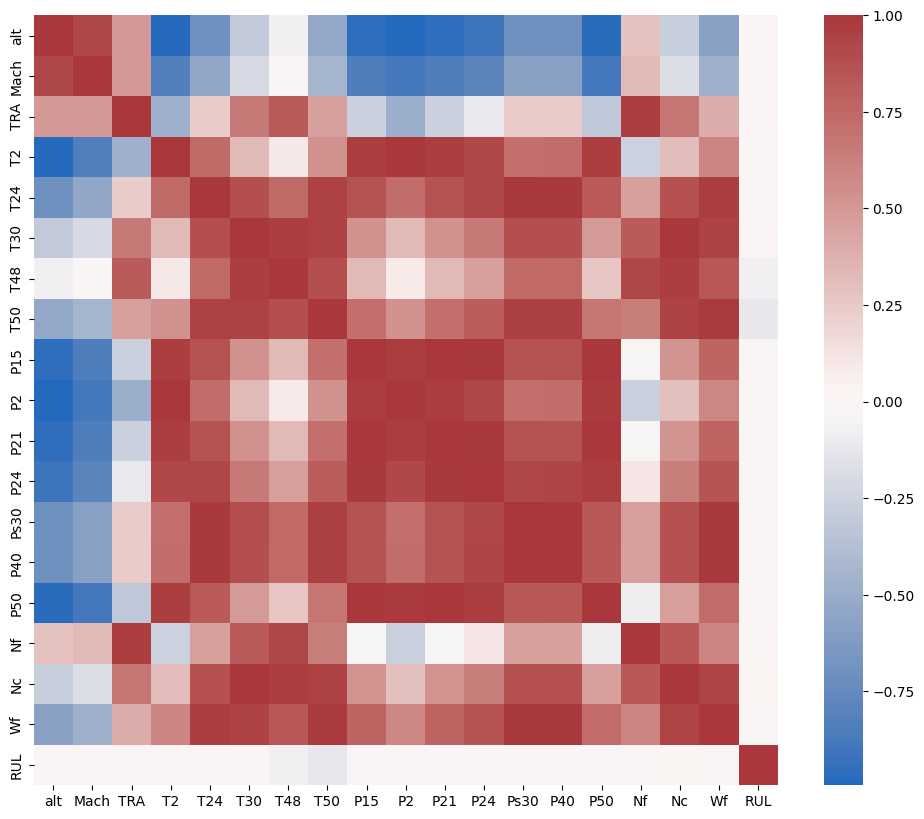

In [10]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(df[W_VAR+XS_VAR+LABELS].corr(), cmap="vlag")

### Flight Traces
visualize a single flight trace of a given unit

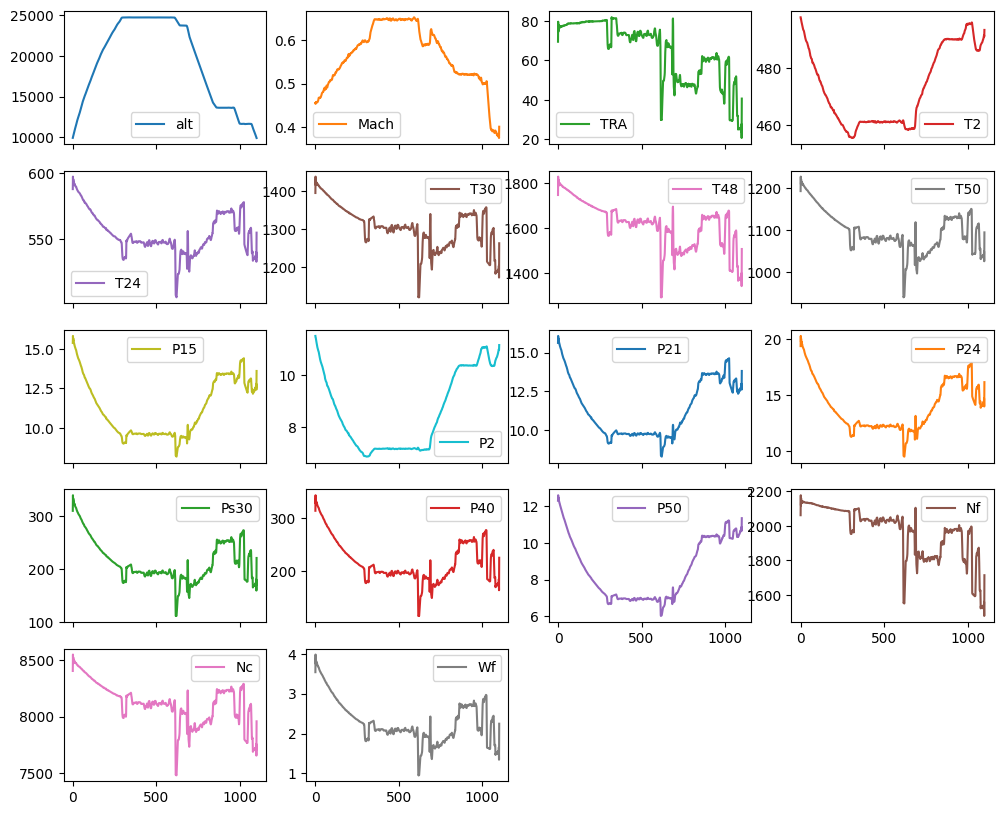

In [11]:
unit = 2
cycle = 16
df_u_sel = df.loc[(df.unit == unit) & (df.cycle == cycle)][W_VAR+XS_VAR]
df_u_sel.reset_index(inplace=True, drop=True)
axes = df_u_sel.plot(figsize=(12, 10), subplots=True, layout=(5, 4))

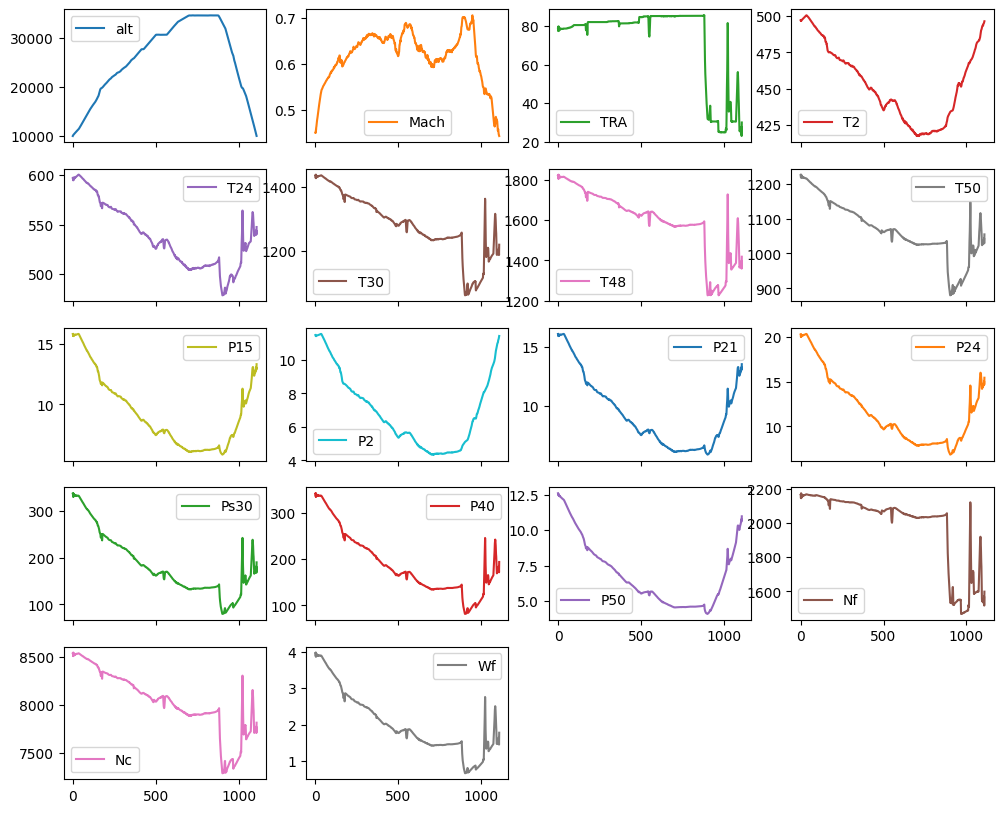

In [12]:
unit = 2
cycle = 17
df_u_sel = df.loc[(df.unit == unit) & (df.cycle == cycle)][W_VAR+XS_VAR]
df_u_sel.reset_index(inplace=True, drop=True)
axes = df_u_sel.plot(figsize=(12, 10), subplots=True, layout=(5, 4))

### Flight envelope

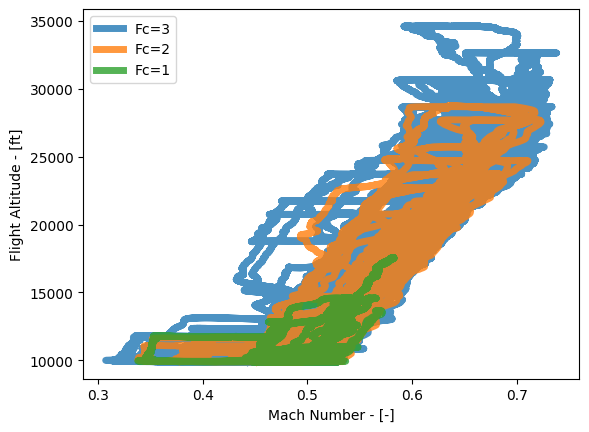

In [13]:
f, ax = plt.subplots(1, 1)
for i in [3, 2, 1]:
    df.loc[df['Fc'] == i].plot(x='Mach', y='alt', alpha=0.8, label=f'Fc={i}', ax=ax, lw=5)
plt.xlabel('Mach Number - [-]')
plt.ylabel('Flight Altitude - [ft]')
plt.legend()

## Histogram of Flight Conditions

/var/folders/94/hphmcz155530jnw34qpssk100000gn/T/ipykernel_21934/1009597741.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', shade=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))
/var/folders/94/hphmcz155530jnw34qpssk100000gn/T/ipykernel_21934/1009597741.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', shade=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))
/var/folders/94/hphmcz155530jnw34qpssk100000gn/T/ipykernel_21934/1009597741.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  

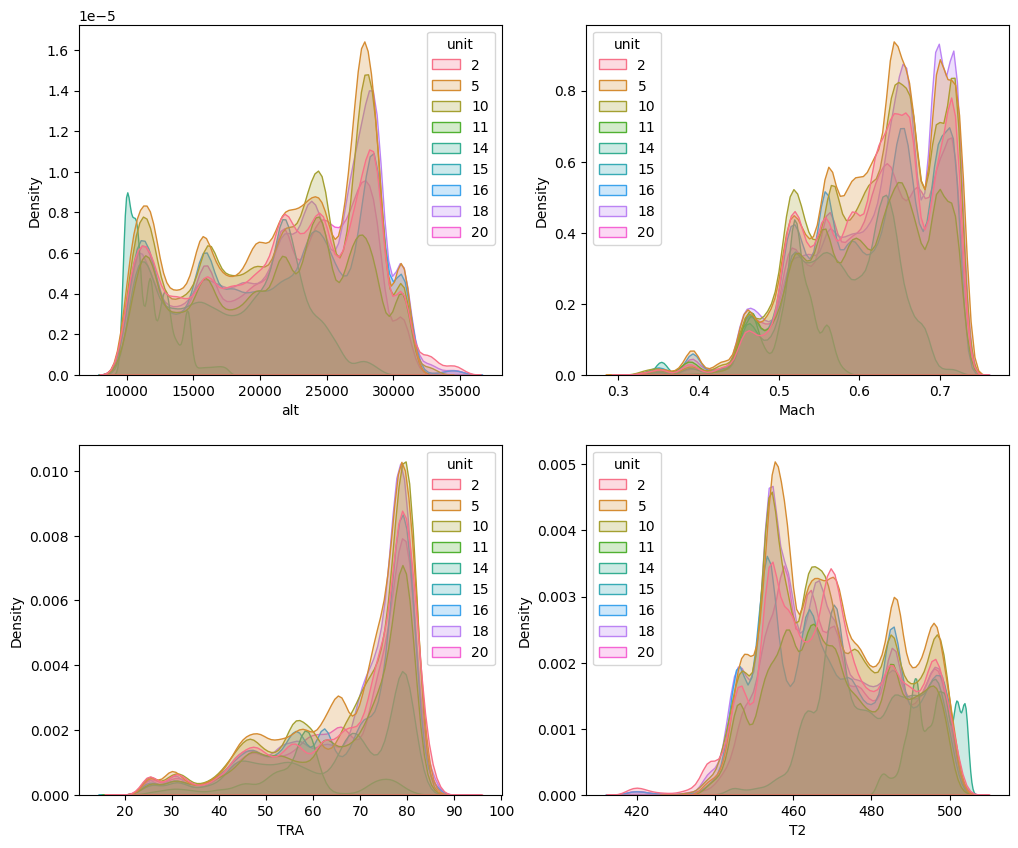

In [14]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, var in enumerate(W_VAR):
    sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', shade=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))

In [15]:
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


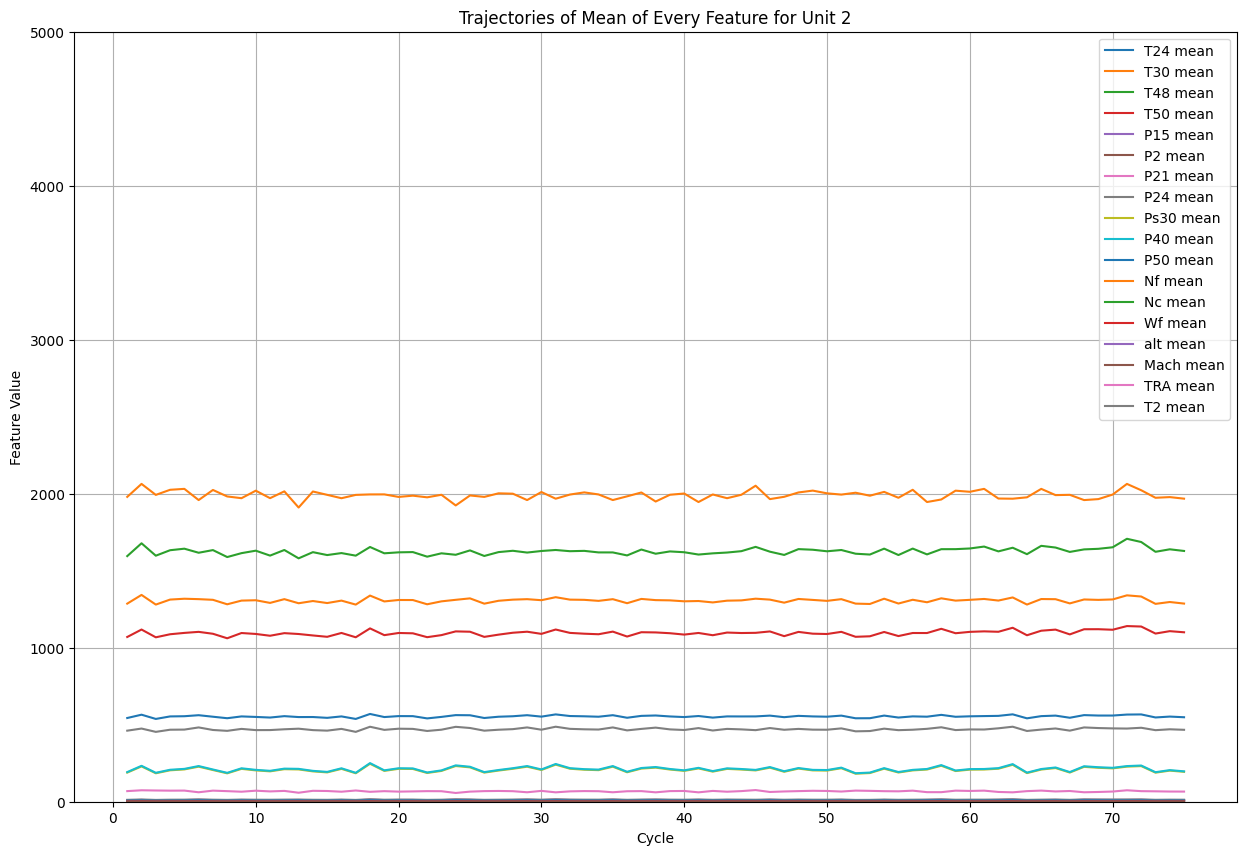

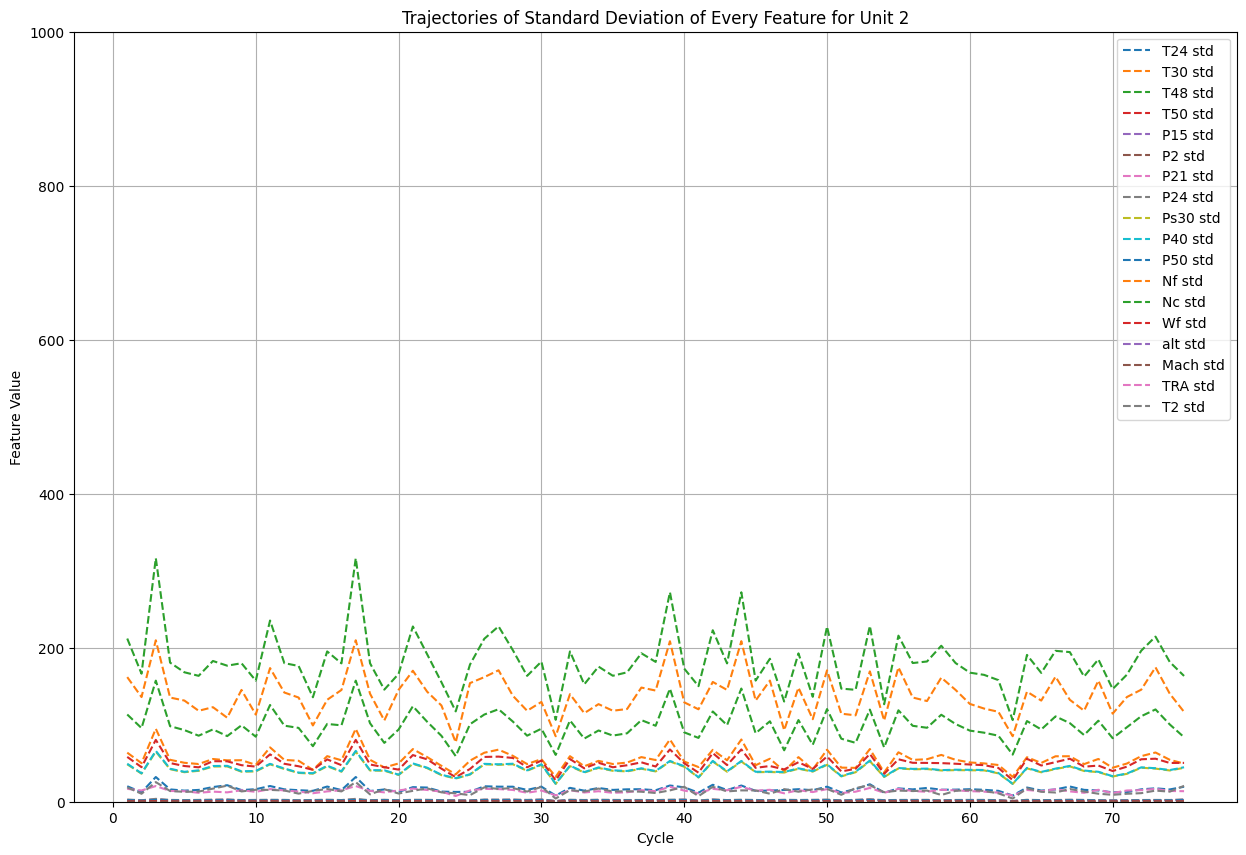

In [16]:
# Filter the DataFrame to include only the data for unit 2
unit_2_data = df[df['unit'] == 2]

# Group the data by cycle and calculate the mean and standard deviation for each feature
grouped_data = unit_2_data.groupby('cycle').agg(['mean', 'std'])

# Plot the trajectories of the mean of every feature for unit 2, restricting the x-axis to 0-5000
plt.figure(figsize=(15, 10))
for column in unit_2_data.columns:
    if column not in ['unit', 'cycle', 'RUL', 'Fc', 'hs']:
        plt.plot(grouped_data.index, grouped_data[(column, 'mean')], label=f'{column} mean')
plt.title('Trajectories of Mean of Every Feature for Unit 2')
plt.xlabel('Cycle')
plt.ylabel('Feature Value')
plt.ylim(0, 5000)
plt.legend()
plt.grid(True)
plt.show()

# Plot the trajectories of the standard deviation of every feature for unit 2, restricting the x-axis to 0-1000
plt.figure(figsize=(15, 10))
for column in unit_2_data.columns:
    if column not in ['unit', 'cycle', 'RUL', 'Fc', 'hs']:
        plt.plot(grouped_data.index, grouped_data[(column, 'std')], label=f'{column} std', linestyle='--')
plt.title('Trajectories of Standard Deviation of Every Feature for Unit 2')
plt.xlabel('Cycle')
plt.ylabel('Feature Value')
plt.ylim(0, 1000)
plt.legend()
plt.grid(True)
plt.show()

# HPT/LPT sensor analysis 

In [ ]:
HPT_SENSORS = ['T48']  # Temperature at HPT outlet
LPT_SENSORS = ['T50', 'P50']  # Temperature and Pressure at LPT outlet
ALL_TURBINE_SENSORS = HPT_SENSORS + LPT_SENSORS

def analyze_sensor_statistics(df):
    """Analyze statistical differences between failure modes"""
    hpt_units = [2, 5, 10]
    complex_units = [16, 18, 20]
    
    stats_df = pd.DataFrame(columns=['Sensor', 'Failure_Mode', 'Early_Mean', 'Late_Mean', 'Change_Percent'])
    
    for sensor in ALL_TURBINE_SENSORS:
        # HPT failure units
        hpt_early = df[(df['unit'].isin(hpt_units)) & (df['cycle'] <= 10)][sensor].mean()
        hpt_late = df[(df['unit'].isin(hpt_units)) & (df['RUL'] <= 10)][sensor].mean()
        hpt_change = ((hpt_late - hpt_early) / hpt_early) * 100
        
        # Complex failure units
        complex_early = df[(df['unit'].isin(complex_units)) & (df['cycle'] <= 10)][sensor].mean()
        complex_late = df[(df['unit'].isin(complex_units)) & (df['RUL'] <= 10)][sensor].mean()
        complex_change = ((complex_late - complex_early) / complex_early) * 100
        
        # Add to dataframe
        stats_df = pd.concat([stats_df, pd.DataFrame({
            'Sensor': [sensor, sensor],
            'Failure_Mode': ['HPT', 'Complex'],
            'Early_Mean': [hpt_early, complex_early],
            'Late_Mean': [hpt_late, complex_late],
            'Change_Percent': [hpt_change, complex_change]
        })])
    
    return stats_df

def analyze_rul_correlation(df):
    """Analyze correlation between sensor values and RUL"""
    hpt_units = [2, 5, 10]
    complex_units = [16, 18, 20]
    
    corr_df = pd.DataFrame(columns=['Sensor', 'Failure_Mode', 'RUL_Correlation'])
    
    for sensor in ALL_TURBINE_SENSORS:
        # Calculate correlation for HPT failure units
        hpt_corr = df[df['unit'].isin(hpt_units)][['RUL', sensor]].corr().iloc[0, 1]
        
        # Calculate correlation for complex failure units
        complex_corr = df[df['unit'].isin(complex_units)][['RUL', sensor]].corr().iloc[0, 1]
        
        # Add to dataframe
        corr_df = pd.concat([corr_df, pd.DataFrame({
            'Sensor': [sensor, sensor],
            'Failure_Mode': ['HPT', 'Complex'],
            'RUL_Correlation': [hpt_corr, complex_corr]
        })])
    
    return corr_df

def run_turbine_analysis(df):
    """Run complete turbine sensor analysis"""
    print("Starting turbine sensor analysis...")
    print("\nSensors being analyzed:")
    print("HPT Sensors:", HPT_SENSORS)
    print("LPT Sensors:", LPT_SENSORS)
    
    # Calculate and display statistics
    stats_df = analyze_sensor_statistics(df)
    print("\nSensor Statistics Summary:")
    print(stats_df.round(2))
    
    # Calculate and display RUL correlations
    corr_df = analyze_rul_correlation(df)
    print("\nCorrelation with RUL:")
    print(corr_df.round(3))
    
    # Additional summary statistics
    print("\nDetailed Summary Statistics by Failure Mode:")
    hpt_units = [2, 5, 10]
    complex_units = [16, 18, 20]
    
    for sensor in ALL_TURBINE_SENSORS:
        print(f"\nSensor: {sensor}")
        print("\nHPT Failure Units:")
        print(df[df['unit'].isin(hpt_units)][sensor].describe().round(2))
        print("\nComplex Failure Units:")
        print(df[df['unit'].isin(complex_units)][sensor].describe().round(2))


In [23]:
run_turbine_analysis(df)

Starting turbine sensor analysis...

Sensors being analyzed:
HPT Sensors: ['T48']
LPT Sensors: ['T50', 'P50']

Sensor Statistics Summary:
  Sensor Failure_Mode  Early_Mean  Late_Mean  Change_Percent
0    T48          HPT     1621.24    1645.44            1.49
1    T48      Complex     1615.26    1641.14            1.60
0    T50          HPT     1089.40    1110.98            1.98
1    T50      Complex     1087.00    1107.00            1.84
0    P50          HPT        7.95       8.07            1.48
1    P50      Complex        7.96       7.80           -1.99


/var/folders/94/hphmcz155530jnw34qpssk100000gn/T/ipykernel_21934/3246539991.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([stats_df, pd.DataFrame({
/var/folders/94/hphmcz155530jnw34qpssk100000gn/T/ipykernel_21934/3246539991.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_df = pd.concat([corr_df, pd.DataFrame({



Correlation with RUL:
  Sensor Failure_Mode  RUL_Correlation
0    T48          HPT           -0.069
1    T48      Complex           -0.087
0    T50          HPT           -0.128
1    T50      Complex           -0.128
0    P50          HPT           -0.033
1    P50      Complex            0.022

Detailed Summary Statistics by Failure Mode:

Sensor: T48

HPT Failure Units:
count    283928.00
mean       1623.83
std          97.85
min        1213.06
25%        1575.35
50%        1633.23
75%        1682.84
max        1920.57
Name: T48, dtype: float64

Complex Failure Units:
count    242417.00
mean       1623.85
std          96.82
min        1209.93
25%        1576.79
50%        1634.92
75%        1678.60
max        1914.64
Name: T48, dtype: float64

Sensor: T50

HPT Failure Units:
count    283928.00
mean       1092.95
std          51.13
min         880.12
25%        1060.07
50%        1084.57
75%        1125.28
max        1273.86
Name: T50, dtype: float64

Complex Failure Units:
count    2